# Import

In [1]:
import os
import sys
import numpy as np
from PIL import Image
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import tifffile
import warnings
import torch




sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data.preprocessing import get_random_crops, run_pipeline
from src.models.sam3_model import SAM3Predictor
from src.utils.visualization import show_crop_sets, show_sam3_predictions
from src.utils.image import evaluate_predictions

warnings.filterwarnings("ignore")
torch.set_default_device('cpu')  # Ensure we use CPU (MPS conflicts on Apple Silicon)

load_dotenv()



c:\Users\DELL\Documents\ProjetEcole\roadgen-cv\mon_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\DELL\Documents\ProjetEcole\roadgen-cv\mon_env\lib\site-packages\torch\amp\autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


True

# Preprocessing

In [4]:
PATH_TO_DATA = "../data/raw/evaluate_sam3/train"
PATH_TO_EXAMPLE_DATA = "../data/examples/evaluate_sam3/original"

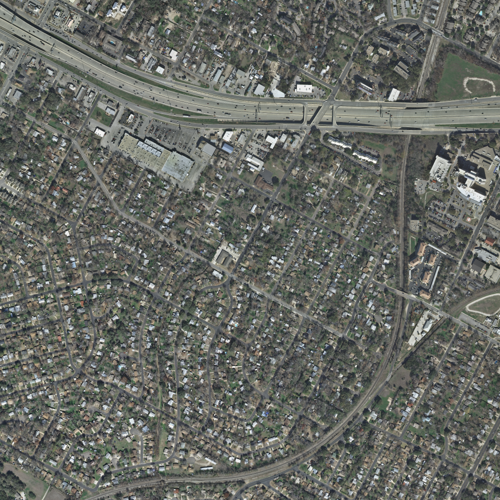

In [5]:
images_dir = Path(PATH_TO_EXAMPLE_DATA) / 'images'
img = Image.open(list(images_dir.iterdir())[0])
img.thumbnail((500, 500))
img

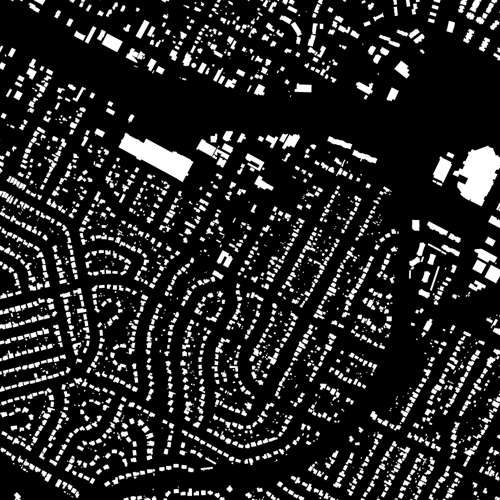

In [6]:
labels_dir = Path(PATH_TO_EXAMPLE_DATA) / 'labels'
lab = Image.open(list(labels_dir.iterdir())[0])
lab.thumbnail((500, 500))
lab

In [7]:
train_crops, label_crops = get_random_crops(
    PATH_TO_EXAMPLE_DATA,
    train_subdir="images",
    labels_subdir="labels",
    patch_size=256,
    num_crops=16
)

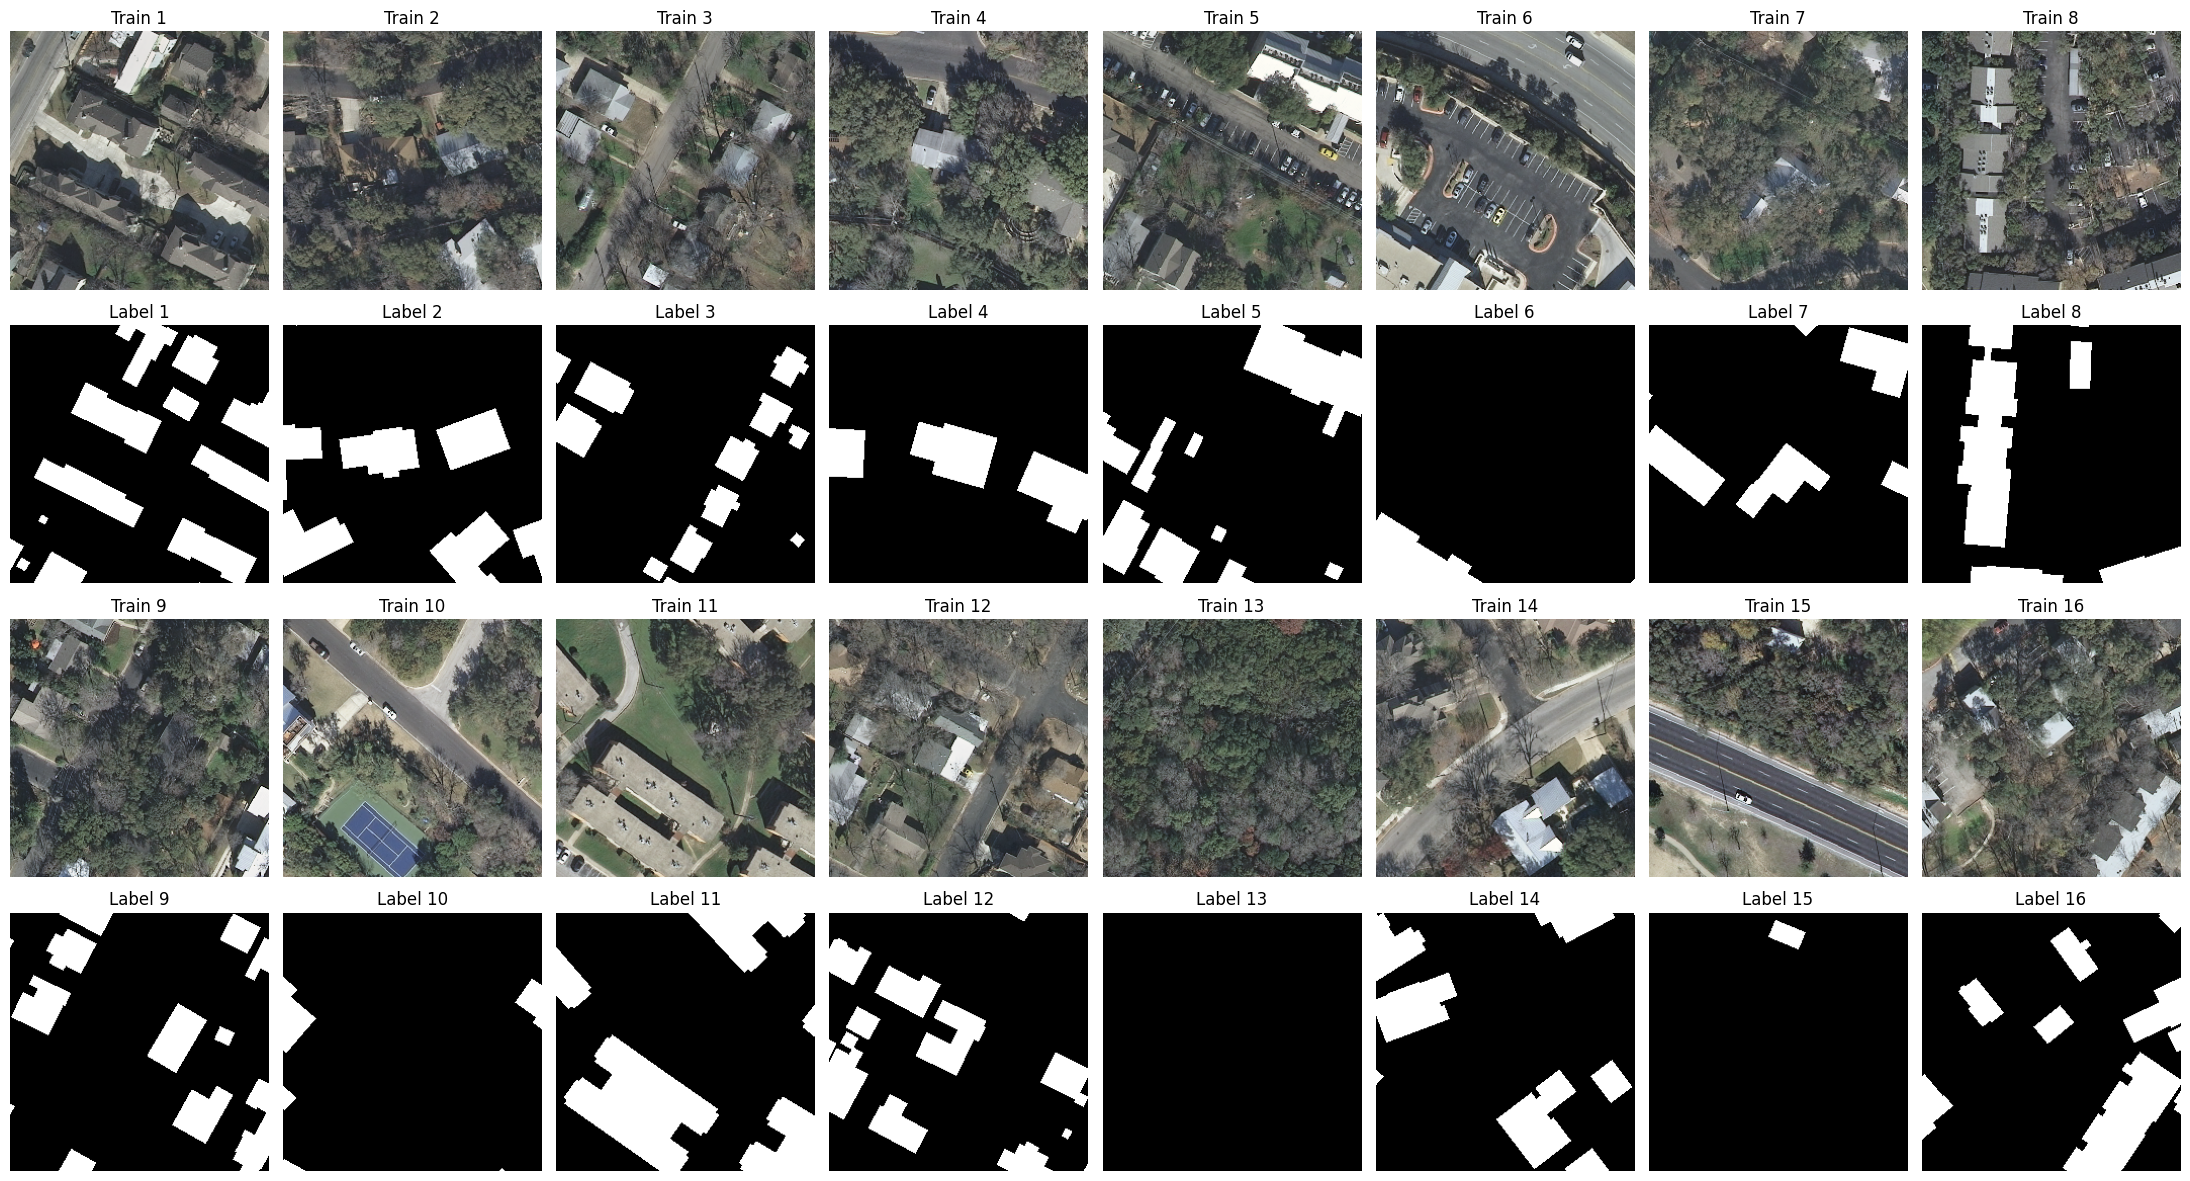

In [8]:
show_crop_sets(train_crops, label_crops)

In [9]:
# Au lieu d'utiliser argparse, définissez directement les paramètres

# Configuration des paramètres
input_dir = "../data/examples/evaluate_sam3/original/"
output_dir = "../data/examples/evaluate_sam3/patches_256/"
filtered_dir = "../data/examples/evaluate_sam3/filtered_patches_256/"
patch_size = 256
train_subdir = "images"
labels_subdir = "labels"
overlap = True  # True = avec overlap, False = sans overlap
train_max_white = 5.0
label_min_white = 2.0

# Exécuter le pipeline
run_pipeline(
    input_dir=input_dir,
    output_dir=output_dir,
    filtered_dir=filtered_dir,
    train_subdir=train_subdir,
    labels_subdir=labels_subdir,
    patch_size=patch_size,
    overlap=overlap,
    train_max_threshold=train_max_white,
    label_min_threshold=label_min_white,
)

Extracting patches from dataset...
Filtering blank patches...
Kept: 79.13% of patches.


{'train_patches': [],
 'label_patches': [],
 'metadata': [{'source_file': 'austin1.tif', 'patch_index': 0, 'x': 0, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 1, 'x': 128, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 2, 'x': 256, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 3, 'x': 384, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 4, 'x': 512, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 5, 'x': 640, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 6, 'x': 768, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 7, 'x': 896, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 8, 'x': 1024, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 9, 'x': 1152, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 10, 'x': 1280, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 11, 'x': 1408, 'y': 0},
  {'source_file': 'austin1.tif', 'patch_index': 12, 'x': 1536, 'y': 0},
  {'source_file': 'austin1.t

# UseSame3 on patches data

In [10]:
PATH_TO_DIRECTORY="../data/examples/evaluate_sam3"
PATH_TO_DATA_FILTERED_PATCHES = Path(PATH_TO_DIRECTORY) / "filtered_patches_256"
PATH_TO_DATA_PATCHES = Path(PATH_TO_DIRECTORY) / "patches"
PATH_TO_DATA_PREDICTIONS = Path(PATH_TO_DIRECTORY) / "sam3_predictions"


In [11]:
predictor = SAM3Predictor()

In [12]:
image = Image.open(f"{PATH_TO_DATA_FILTERED_PATCHES}/images/austin1_patch_008_x1024_y0.png")
prompt = 'building'

masks = predictor.predict_and_merge(image, prompt)

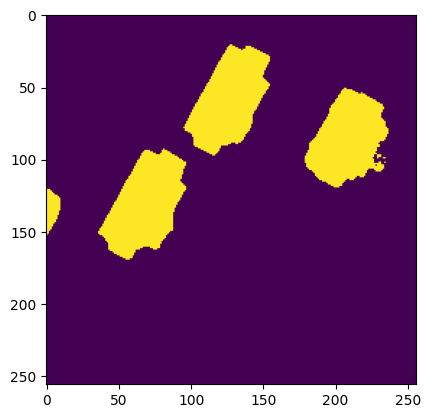

In [13]:
plt.imshow(masks)

### Predict with Sam3 for all images in patches

In [14]:
predictor.predict_and_process_directory(
    directory_path=PATH_TO_DATA_PATCHES,
    train_subdir='images',
    label_subdir='labels',
    prompt='building'
)

Processing patches: 100%|██████████| 4/4 [03:48<00:00, 57.11s/patch]

All set processed!


# Evaluate Sam3

In [15]:
base_labels_dir = Path(f'{PATH_TO_DATA_PATCHES}/labels')
sam3_labels_dir = PATH_TO_DATA_PREDICTIONS
stems = [img_path.rstrip('.png') for img_path in os.listdir(base_labels_dir)]

img2label = {base_labels_dir / (stem + '.png'): sam3_labels_dir / (stem + '_processed.tiff') for stem in stems}

In [16]:
true_paths, pred_paths = zip(*tuple(img2label.items())[:16])

true_imgs = [Image.open(path)for path in true_paths]
pred_imgs = [tifffile.imread(path)for path in pred_paths]

In [17]:
true_paths, pred_paths = zip(*tuple(img2label.items())[:16])

# Vérifier les tailles
for true_path, pred_path in list(zip(true_paths, pred_paths))[:5]:  # Afficher les 5 premiers
    train_size = Image.open(true_path).size
    label_size = tifffile.imread(pred_path).shape
    print(f"Train: {train_size} | Label: {label_size} | Match: {train_size == label_size[::-1]}")
    print(f"  {true_path.name}")
    print(f"  {pred_path.name}\n")

train_imgs = [Image.open(path) for path in true_paths]
label_imgs = [tifffile.imread(path) for path in pred_paths]

Train: (256, 256) | Label: (256, 256, 2) | Match: False
  austin1_patch_021_x2688_y0.png
  austin1_patch_021_x2688_y0_processed.tiff

Train: (256, 256) | Label: (256, 256, 2) | Match: False
  austin1_patch_033_x4224_y0.png
  austin1_patch_033_x4224_y0_processed.tiff

Train: (256, 256) | Label: (256, 256, 2) | Match: False
  austin1_patch_042_x512_y128.png
  austin1_patch_042_x512_y128_processed.tiff

Train: (256, 256) | Label: (256, 256, 2) | Match: False
  austin1_patch_054_x2048_y128.png
  austin1_patch_054_x2048_y128_processed.tiff



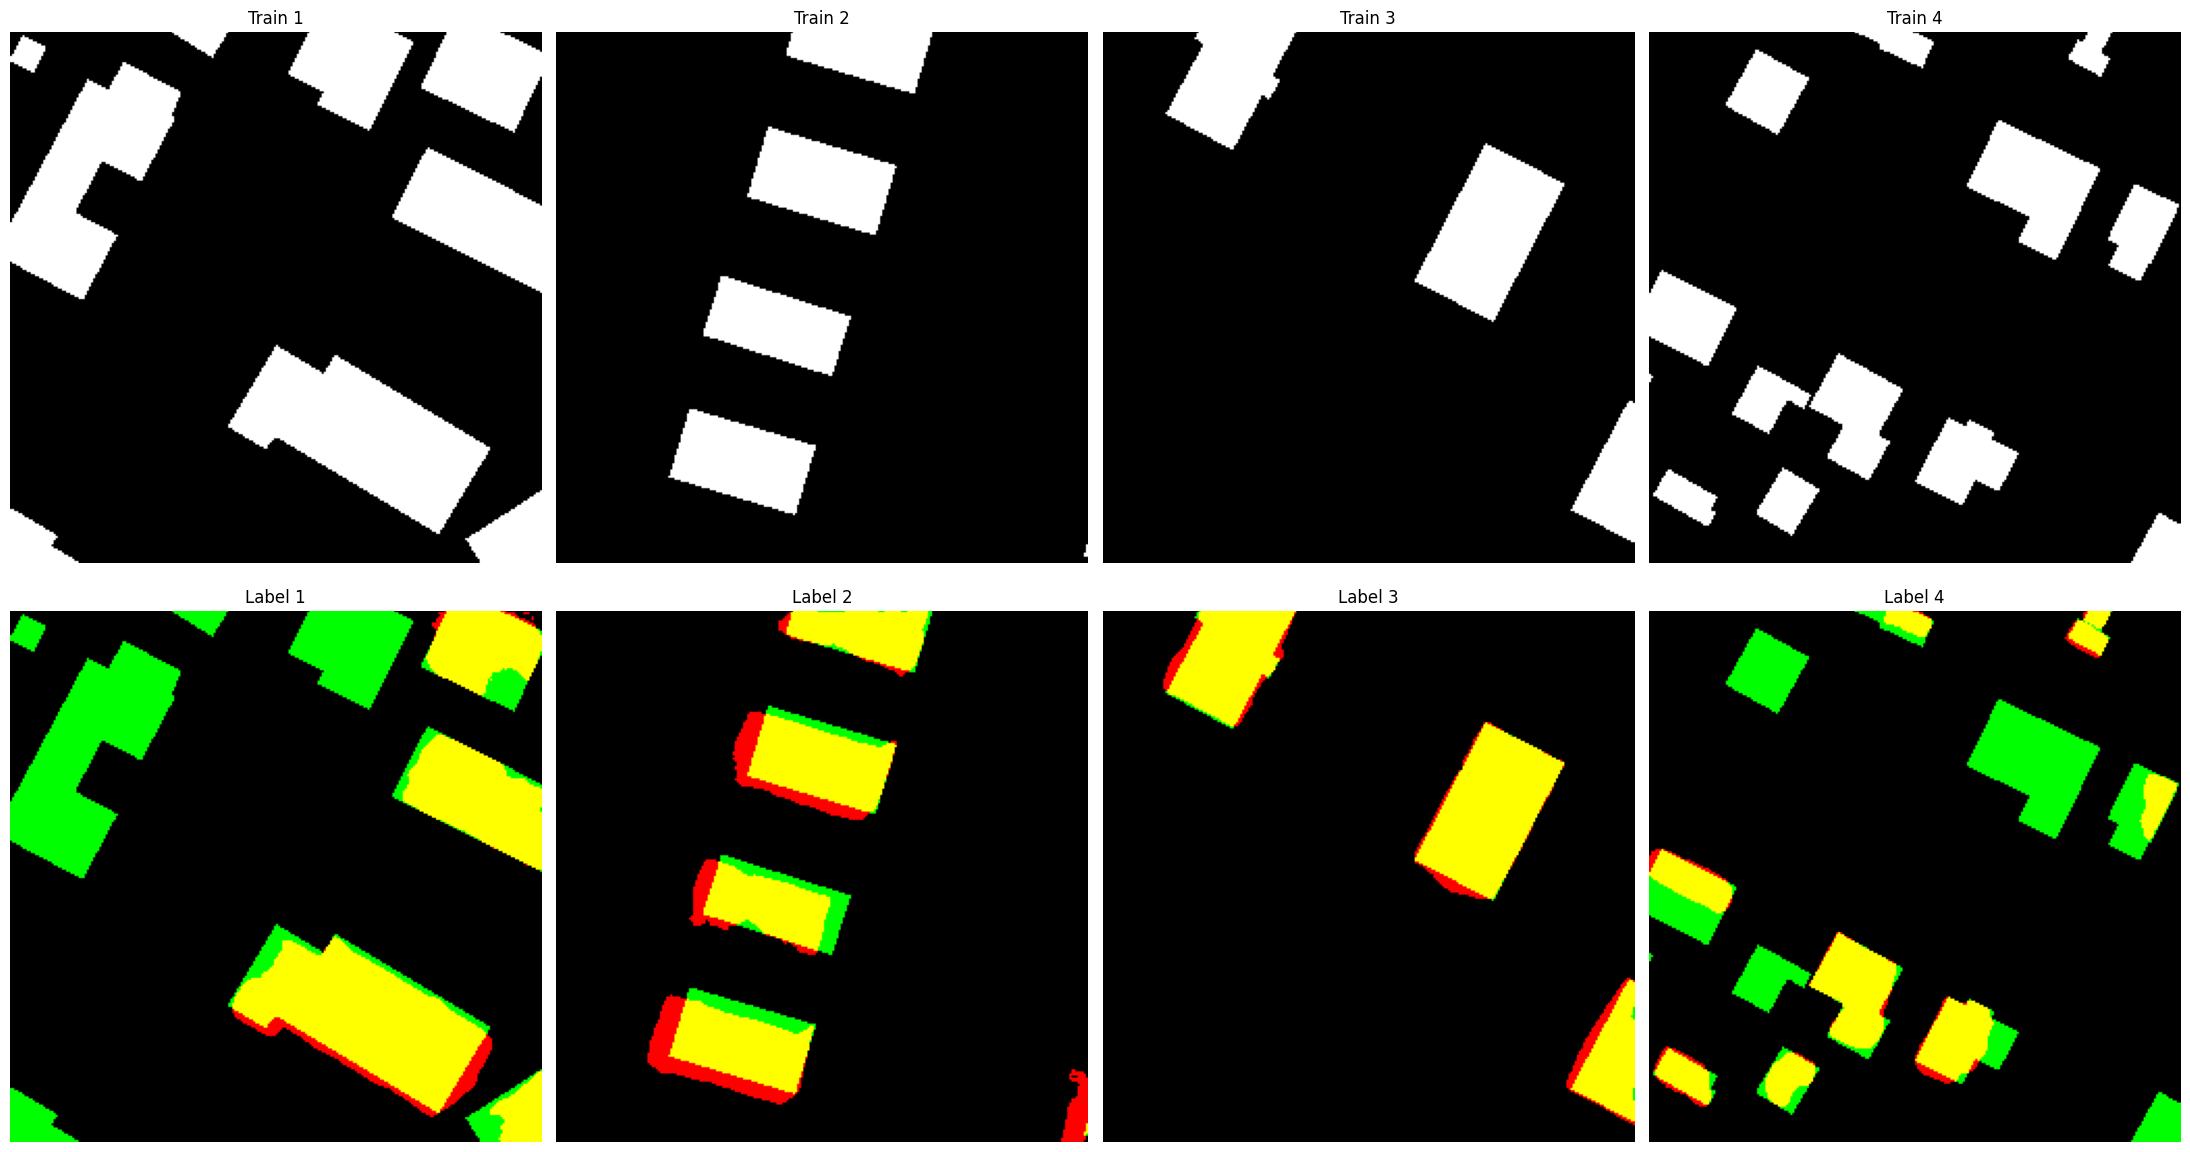

In [19]:
show_sam3_predictions(true_imgs, pred_imgs, images_per_row=4, num_sets=1)

### Display average stats

In [20]:
results = evaluate_predictions(img2label, threshold=0.5)
for metric, value in results['average'].items():
    std_value = results['std'][f'{metric}_std']
    print(f"{metric:15s}: {value:.4f} ± {std_value:.4f}")


IoU            : 0.9044 ± 0.0716
Dice           : 0.9483 ± 0.0407
Precision      : 0.9044 ± 0.0716
Recall         : 1.0000 ± 0.0000
F1-Score       : 0.9483 ± 0.0407
Accuracy       : 0.9852 ± 0.0102
Specificity    : 0.9826 ± 0.0113


### Display all stats

In [21]:
results = evaluate_predictions(img2label, threshold=0.5,isAverage=False)

if results:
    # Afficher chaque image individuellement
    for i, res in enumerate(results, 1):
        print(f"\n{'='*60}")
        print(f"Image {i}: {res['true_path']}")
        print(f"{'='*60}")
        print(f"  IoU         : {res['IoU']:.4f}")
        print(f"  Dice        : {res['Dice']:.4f}")
        print(f"  Precision   : {res['Precision']:.4f}")
        print(f"  Recall      : {res['Recall']:.4f}")
        print(f"  F1-Score    : {res['F1-Score']:.4f}")
        print(f"  Accuracy    : {res['Accuracy']:.4f}")
        print(f"  Specificity : {res['Specificity']:.4f}")
        print(f"  TP/TN/FP/FN : {res['TP']}/{res['TN']}/{res['FP']}/{res['FN']}")
    
else:
    print("No results")


Image 1: austin1_patch_021_x2688_y0.png
  IoU         : 0.9639
  Dice        : 0.9816
  Precision   : 0.9639
  Recall      : 1.0000
  F1-Score    : 0.9816
  Accuracy    : 0.9898
  Specificity : 0.9860
  TP/TN/FP/FN : 17804/47066/666/0

Image 2: austin1_patch_033_x4224_y0.png
  IoU         : 0.7895
  Dice        : 0.8823
  Precision   : 0.7895
  Recall      : 1.0000
  F1-Score    : 0.8823
  Accuracy    : 0.9679
  Specificity : 0.9636
  TP/TN/FP/FN : 7878/55557/2101/0

Image 3: austin1_patch_042_x512_y128.png
  IoU         : 0.8987
  Dice        : 0.9467
  Precision   : 0.8987
  Recall      : 1.0000
  F1-Score    : 0.9467
  Accuracy    : 0.9889
  Specificity : 0.9877
  TP/TN/FP/FN : 6434/58377/725/0

Image 4: austin1_patch_054_x2048_y128.png
  IoU         : 0.9655
  Dice        : 0.9825
  Precision   : 0.9655
  Recall      : 1.0000
  F1-Score    : 0.9825
  Accuracy    : 0.9943
  Specificity : 0.9932
  TP/TN/FP/FN : 10497/54664/375/0
